In [107]:
import os
os.chdir('d:/future/Index_Future_Prediction')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import optuna
import math

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from torch.utils.data import TensorDataset, DataLoader

from utils import *
from modules import *

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [108]:
class PanelTransformerBackbone(nn.Module):
    def __init__(self, dim_patch_feature, dim_projection, dim_temporal_embedding, dim_assets_embedding, num_bass_assets, num_head, num_layer, dropout):
        super().__init__()
        dim_encoder_input = dim_projection +  dim_temporal_embedding + dim_assets_embedding
        self.projection = nn.Linear(dim_patch_feature, dim_projection)
        self.assets_embedding = AssetsEmbedding(num_base_assets = num_bass_assets, embedding_dim = dim_assets_embedding, target_ratio = 0.2, freeze = True)
        self.temporal_embedding = TemporalEmbedding(dim_embedding = dim_temporal_embedding)
        self.panel_encoder = MultiLayerPanelEncoder(num_layer = num_layer, d_model = dim_encoder_input, num_head = num_head, num_ffn_hidden = dim_encoder_input * 2, dropout = dropout)

    def forward(self, x, weights):
        x = self.projection(x)
        x = self.temporal_embedding(x)
        x = self.assets_embedding(x, weights)
        x = self.panel_encoder(x)
        return x

model = PanelTransformerBackbone(dim_patch_feature = 120, dim_projection = 128, dim_temporal_embedding = 6, dim_assets_embedding = 10, num_bass_assets = 53, num_head = 8, num_layer = 3 , dropout = 0.5)
model.assets_embedding.load_state_dict(torch.load('params/assets_embedding.params'))

<All keys matched successfully>

In [109]:
class SimpletaskPanelTransformer(nn.Module):
    """Panel Time Series Transformer"""
    def __init__(self, dim_raw_feature, patch_size, stride, mask_expand_size, seq_len, dim_projection, dim_temporal_embedding, dim_assets_embedding, num_bass_assets, num_head, num_layer, dropout):
        super().__init__()
        # 模型参数
        self.device = 'cuda:0'
        self.input_size = dim_raw_feature
        self.patch_size = patch_size
        self.stride = stride
        self.mask_expand_size = mask_expand_size
        self.num_patch = int(np.floor((seq_len - patch_size) / stride) + 1)

        self.dim_projection = dim_projection

        dim_encoder_input = dim_projection +  dim_temporal_embedding + dim_assets_embedding

        # 前置层
        self.patch = TimeSeriesPatcher(patch_size, stride)

        # 编码层
        self.encoder = PanelTransformerBackbone(dim_patch_feature = dim_raw_feature * patch_size,
                                                  dim_projection = dim_projection,
                                                  dim_temporal_embedding = dim_temporal_embedding,
                                                  dim_assets_embedding = dim_assets_embedding,
                                                  num_bass_assets = num_bass_assets,
                                                  num_head = num_head,
                                                  num_layer = num_layer,
                                                  dropout = dropout)

        # 简单的单资产独立预测输出层
        self.decoder = nn.Sequential(
            nn.Flatten(start_dim = -2),
            nn.Linear(self.num_patch * dim_encoder_input, self.num_patch *dim_encoder_input),
            nn.Dropout(dropout),
            HybridDecoder(dim_state = self.num_patch * dim_encoder_input, init_prob = [0.0,0.0,0.0])
        )
    
    def forward(self, x, weights):
        x_patched = self.patch(x)
        enc_out = self.encoder(x_patched, weights)
        output = self.decoder(enc_out)
        return output
    
    # 重写 train 方法，来固定模型只训练输出层
    def train(self, mode = True):
        super().train(mode)
        if mode:
            self.encoder.eval()


In [110]:
dim_raw_feature = 10
patch_size = 8
stride = 4
mask_expand_size = 1
seq_len = 120
dim_projection = 112
dim_temporal_embedding = 6
dim_assets_embedding = 10
num_bass_assets = 53
num_head = 8
num_layer = 3
dropout = 0.7

batch_size = 64
learning_rate = 1e-4
weight_decay = 1e-4
gamma = 1

test_size = 128
epochs = 10

alpha = 0.03
delta = 1.2

In [111]:
model = SimpletaskPanelTransformer(dim_raw_feature, patch_size, stride, mask_expand_size, seq_len, dim_projection, dim_temporal_embedding, dim_assets_embedding, num_bass_assets, num_head, num_layer, dropout)
model.encoder.load_state_dict(torch.load('params/panel_tf_backbone.params'))

<All keys matched successfully>

In [112]:
# 加载数据
loaders = []
for i in [20110901, 20160901, 20210901]:

    feature = torch.load(f'data/feature_{i}')
    label = torch.load(f'data/label_{i}')
    weights = torch.load(f'data/weights_{i}')

    train_set = TensorDataset(feature[:-256], weights[:-256], label[:-256])
    train_loader = DataLoader(train_set, batch_size, True)
    loaders.append(train_loader)


feature = torch.load('data/feature_20210901')
label = torch.load('data/label_20210901')
weights = torch.load('data/weights_20210901')
test_set = TensorDataset(feature[-128:], weights[-128:], label[-128:])
test_loader = DataLoader(test_set, batch_size, False)

# test_loader 只需要最新的就行了，因为是一样的，重复test没意义

In [113]:
train_recorder = PredictionRecorder()
test_recorder = PredictionRecorder()
graph = TrainMonitor(figsize=(12,6))

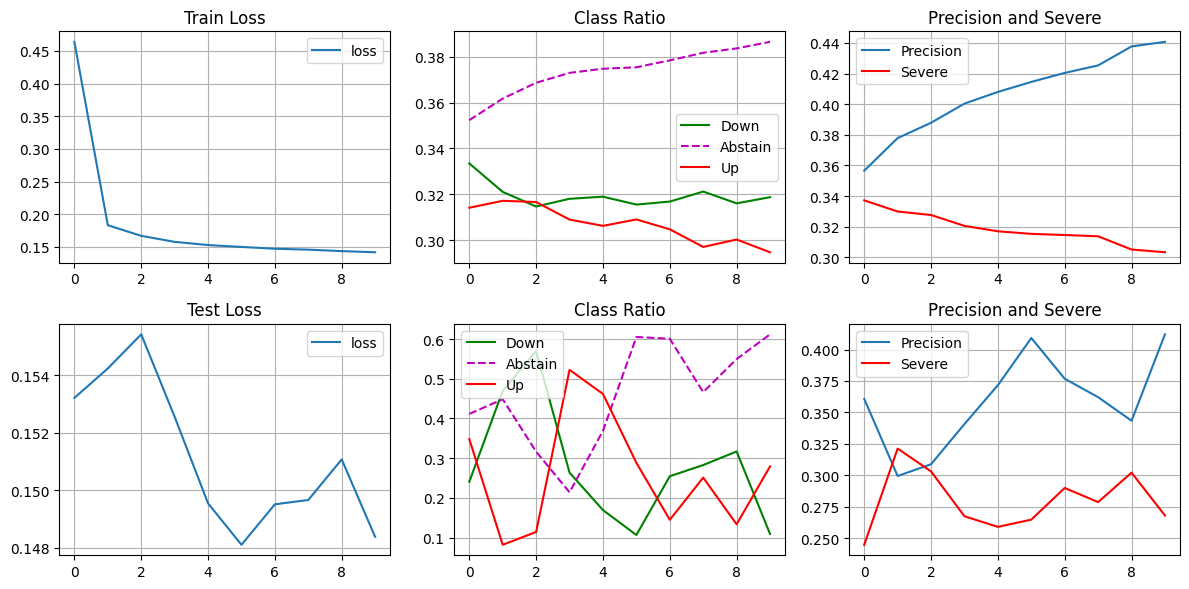

100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


0


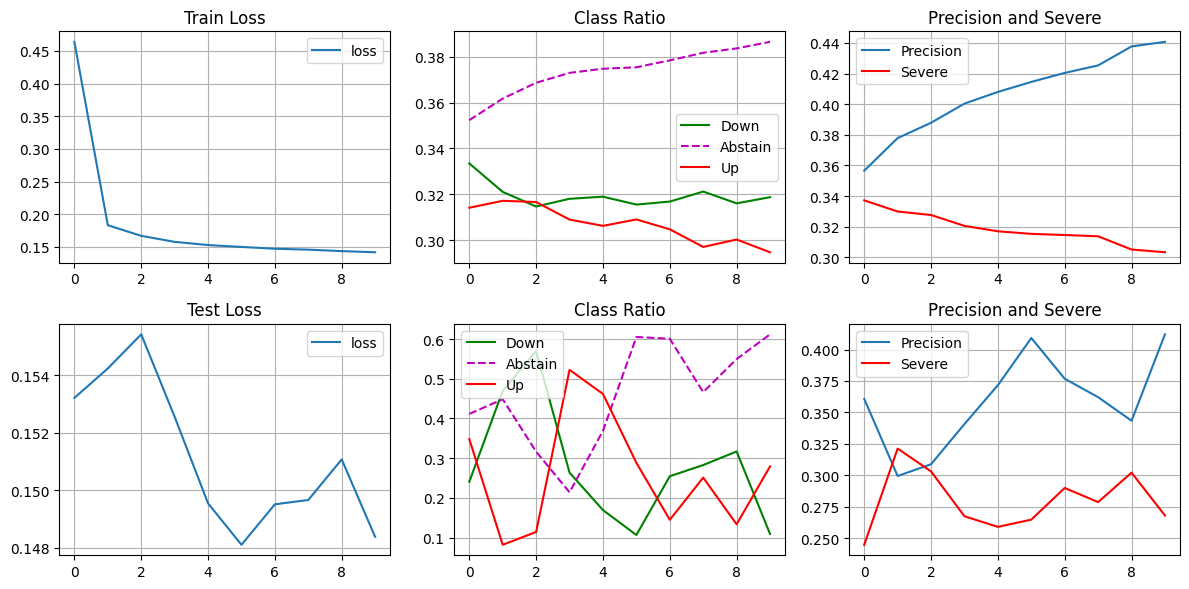

In [114]:
# 预训练
loss_fn = HybridLoss(alpha = alpha, delta = delta, show_loss = False)

model = SimpletaskPanelTransformer(
    dim_raw_feature,
    patch_size,
    stride,
    mask_expand_size,
    seq_len,
    dim_projection,
    dim_temporal_embedding,
    dim_assets_embedding,
    num_bass_assets,
    num_head,
    num_layer,
    dropout
).to('cuda:0')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)


def epoch():

    train_recorder.clear()
    test_recorder.clear()

    train_losses = []
    model.train()
    for loader in loaders:
        for batch_x, batch_weights, batch_y in loader:
            optimizer.zero_grad()
            pred = model(batch_x.to('cuda:0'), batch_weights.to('cuda:0'))
            loss = loss_fn(pred, batch_y.to('cuda:0'))
            train_recorder.add(pred, batch_y.to('cuda:0'))
            train_losses.append(loss.item()) 
            loss.backward()
            optimizer.step()
        
    test_losses = []
    model.eval()
    with torch.no_grad():
        for batch_x, batch_weights, batch_y in test_loader:
            pred = model(batch_x.to('cuda:0'), batch_weights.to('cuda:0'))
            loss = loss_fn(pred, batch_y.to('cuda:0'))
            test_recorder.add(pred, batch_y.to('cuda:0'))
            test_losses.append(loss.item()) 

    train_summarys = train_recorder.summary()
    test_summarys = test_recorder.summary()
    
    return np.mean(train_losses), tuple(train_summarys.iloc[:3,0]), tuple(train_summarys.iloc[3,1:3]), np.mean(test_losses), tuple(test_summarys.iloc[:3,0]), tuple(test_summarys.iloc[3,1:3]),


def train(epochs = 30):

    for i in tqdm.tqdm(range(epochs)):
        train_loss, train_summary, train_score, test_loss, test_summary, test_score = epoch()
        graph.add(i, train_loss, subplot_idx = 0)
        graph.add(i, train_summary, subplot_idx = 1)
        graph.add(i, train_score, subplot_idx = 2)
        graph.add(i, test_loss, subplot_idx = 3)
        graph.add(i, test_summary, subplot_idx = 4)
        graph.add(i, test_score, subplot_idx = 5)
        graph.draw()
        scheduler.step()
    return 0

final_loss = train(epochs)
print(final_loss)

In [115]:
# del loaders
# del train_loader
# del train_set

first date of test set: 20230901
last date of test set: 20250829

In [116]:
# 加载测试数据
feature = torch.load('data/feature_test').to('cuda:0')
label = torch.load('data/label_test').to('cuda:0')
weights = torch.load('data/weights_test').to('cuda:0')
test_set = TensorDataset(feature, weights, label)
test_loader = DataLoader(test_set, 32, False)


In [117]:
model.eval()
test_result = []
for x, weights, y in test_loader:
    result = model(x, weights).detach().cpu().numpy()
    test_result.append(result)
test_result = np.concatenate(test_result, axis = 0)
test_result.shape

(483, 53, 4)

In [118]:
assets_list = [
    # 股指期货
    'IH.CFX', 'IF.CFX', 'IC.CFX',
    # 国债期货
    'TS.CFX', 'TF.CFX', 'T.CFX', 'TL1.CFX',
    # 黑色金属产业链
    'I.DCE', 'JM.DCE', 'RB.SHF', 'HC.SHF', 'SS.SHF', 'SF.ZCE', 'SM.ZCE',
    # 有色金属
    'CU.SHF', 'AL.SHF', 'ZN.SHF', 'NI.SHF',
    # 贵金属
    'AU.SHF', 'AG.SHF',
    # 能源化工
    'FU.SHF', 'LU.INE', 'BU.SHF', 'PG.DCE', 'TA.ZCE', 'EG.DCE', 'PF.ZCE', 
    'L.DCE', 'PP.DCE', 'V.DCE', 'EB.DCE', 'MA.ZCE', 'UR.ZCE', 'RU.SHF',
    # 农产品
    'A.DCE', 'B.DCE', 'M.DCE', 'RM.ZCE', 'Y.DCE', 'OI.ZCE', 'P.DCE', 'PK.ZCE',
    'C.DCE', 'CS.DCE', 'CF.ZCE', 'SR.ZCE', 'CJ.ZCE', 'AP.ZCE', 'SP.SHF', 
    'JD.DCE', 'LH.DCE',
    # 建材
    'FG.ZCE', 'SA.ZCE'
]


In [143]:
import backtrader as bt

class TargetPositionStrategy(bt.Strategy):
    """
    简单单资产策略，对每个资产都一视同仁，不考虑相关性
    """
    params = (
        ('lookback', 5),
        ('capital_per_asset', 100000.0),  # 每个资产分配的固定金额
    )

    def __init__(self):
        self.log_dates = []
        self.log_values = []
        self.log_cash = []

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        
    def next(self):
        # 记录每日的总资产价值
        self.log_dates.append(self.data.datetime.date(0))
        self.log_values.append(self.broker.getvalue())
        self.log_cash.append(self.broker.getcash())


        # 遍历所有传入的数据（即所有资产）
        for d in self.datas:
            # 如果数据点不足以覆盖回望期，则跳过
            if len(d) < self.p.lookback:
                continue
            # 从 openinterest 获取预先计算好的信号
            signals = d.openinterest.get(size=self.p.lookback)
            signal_sum = sum(signals)
            target_pct = signal_sum / self.p.lookback
            # 计算目标仓位价值。
            target_value = self.p.capital_per_asset * target_pct
            # 调仓
            self.order_target_value(data=d, target=target_value)
    
    def stop(self):
        for d in self.datas:
            # 如果仍持有头寸 (无论是多头还是空头)，都通过将目标价值设为0来平仓
            if self.getposition(d).size != 0:
                self.log(f"Closing position for {d._name} at stop.")
                self.order_target_value(data=d, target=0.0)

53个资产，每个资产10w资金

但是由于每个资产有平均33%的概率空仓，且多空会相互抵消，最低现金： 3259560.20 平均现金 5602421.22，存在大量的闲置资金，因此可以适当放大杠杆到1倍杠杆

In [144]:
from datetime import datetime
cerebro = bt.Cerebro()
start_date = datetime(2023,9,1)
end_date = datetime(2025,9,1)

for i in range(len(assets_list)):

    asset_code = assets_list[i]

    output = test_result[:,i,:]
    prob_prediction = np.argmax(output[:,1:], axis = 1) - 1  # 转换为 -1, 0, +1 的方向表示

    data = pd.read_csv(f'data/{asset_code}.csv')
    data = data[data['trade_date'] >= 20230901].copy()
    data = data[data['trade_date'] < 20250901].copy()

    data['trade_date'] = pd.to_datetime(data['trade_date'], format = '%Y%m%d')
    data.index = data['trade_date']
    days = data['trade_date']
    position = pd.Series(index = days, data = prob_prediction, name = 'openinterest') # 为了方便，我们直接覆盖掉没使用的open interest
    data = data.join(position, how='left')

    data['volume'] = data['vol']
    data = data[['open', 'high', 'low', 'close', 'volume', 'openinterest']].copy()
    feed_data = bt.feeds.PandasData(dataname=data, fromdate=start_date, todate=end_date, name = asset_code)  # 加载数据
    cerebro.adddata(feed_data)


cerebro.broker.setcash(2600000.0) 
cerebro.broker.setcommission(commission=0.0001)
cerebro.addstrategy(TargetPositionStrategy)
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn', timeframe=bt.TimeFrame.Days)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', timeframe=bt.TimeFrame.Days, compression=1, riskfreerate=0.02, factor=252, annualize = True)
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
results = cerebro.run()

print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")
strategy_instance = results[0]

# 年化收益
returns_analysis = strategy_instance.analyzers.returns.get_analysis()
print(f"Annualized Return: {returns_analysis.get('rnorm', 'N/A'):.2%}")
    
# 年化标准差
timereturn_analysis = strategy_instance.analyzers.timereturn.get_analysis()
daily_returns = pd.Series(timereturn_analysis)
std_dev_daily = daily_returns.std()
print(f"Annualized Std: {std_dev_daily * math.sqrt(252):.2%}")
# 夏普比率
sharpe_analysis = strategy_instance.analyzers.sharpe.get_analysis()
print(f"Sharpe Ratio: {sharpe_analysis.get('sharperatio', 'N/A'):.4f}")
# 最大回撤
drawdown_analysis = strategy_instance.analyzers.drawdown.get_analysis()
print(f"Max Drawdown: {drawdown_analysis.max.get('drawdown', 'N/A'):.2f}%")
# 胜率
trades_analysis = strategy_instance.analyzers.trades.get_analysis()
print(f"Total Trades: {trades_analysis.total.total}")
print(f"Win Rate: {(trades_analysis.won.total / trades_analysis.total.total) * 100:.2f}%")
print(f"Average PnL per Trade: {trades_analysis.pnl.net.average:.2f}")

Final Portfolio Value: 3033014.30
Annualized Return: 8.37%
Annualized Std: 5.59%
Sharpe Ratio: 1.1127
Max Drawdown: 3.39%
Total Trades: 1459
Win Rate: 56.68%
Average PnL per Trade: 314.65


最低现金559,560.20, 平均现金: 2,902,421.23


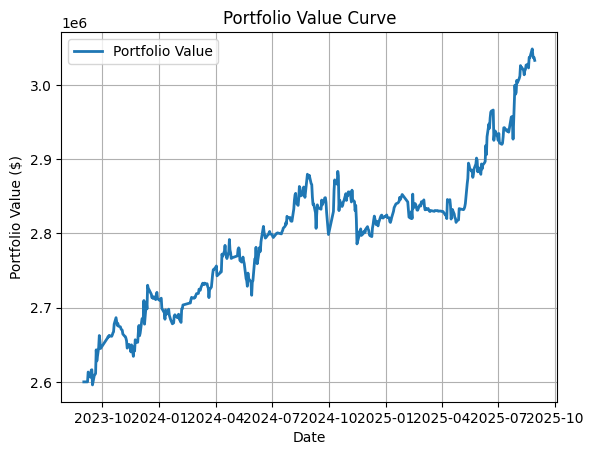

In [161]:
log_dates = strategy_instance.log_dates
log_values = strategy_instance.log_values
log_cash = strategy_instance.log_cash
equity_curve = pd.Series(log_values, index=pd.to_datetime(log_dates))
print(f'最低现金{np.min(log_cash):,.2f}, 平均现金: {np.mean(log_cash):,.2f}')

plt.plot(figsize=(10, 10))
plt.plot(equity_curve.index, equity_curve.values, label='Portfolio Value', linewidth=2)
plt.title('Portfolio Value Curve')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()